In [5]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
from tqdm import tqdm

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from feature_decomp import generate_fra_monomials
from utils import ensure_torch, ensure_numpy
from data import get_powerlaw, get_gaussian_data
from kernels import GaussianKernel, LaplaceKernel

In [5]:
# SETUP FILE MANAGEMENT
#######################

EXPT_NAME = "exponent"
DATASET = "cifar10"

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET)

if not os.path.exists(expt_dir):
    os.makedirs(expt_dir)
expt_fm = FileManager(expt_dir)

In [39]:
DATA_DIM = 30
KERNEL_WIDTH = 4
P_MODES = 100_000
kerneltype = LaplaceKernel
data_eigval_exp = 1.01

data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=3)

d_eff = 1/(data_eigvals**2).sum()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)
fra_eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
degrees = np.array([m.degree() for m in monomials])

effective dim = 17.80


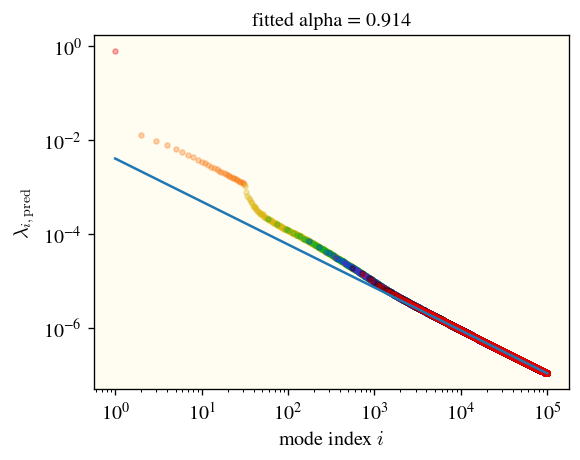

In [41]:
def fit_linear(idxs, eigvals, cutoff=20_000):
    log_x = np.log(idxs[-cutoff:])
    log_y = np.log(eigvals[-cutoff:])
    A     = np.vstack([log_x, np.ones_like(log_x)]).T
    slope, intercept = np.linalg.lstsq(A, log_y, rcond=None)[0]

    alpha = -slope

    return alpha, np.exp(intercept)


colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

for degree in np.unique(degrees):
    if degree > 7:
        continue
    idxs = np.where(np.array(degrees) == degree)[0]
    ax.scatter(1+idxs, fra_eigvals[idxs], color=colors[degree%7], marker='.', alpha=0.3)

idxs = 1+np.arange(len(fra_eigvals))
alpha, c = fit_linear(idxs, fra_eigvals, cutoff=80_000)
ax.plot(idxs, c*idxs**(-alpha))
ax.set_title(f"fitted alpha = {alpha:.3f}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'mode index $i$')
ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')

plt.tight_layout()
plt.show()